# GDAA 2010 Data Mining: Project 2
### By: Tato' Crisanto
### For: Dr. Steven Edwards

The purpose of this project is to gain experience in making predictions on unlabelled image data using Python-based Deep Learning Models. I will be using PyTorch to accomplish this task.

#### Installing PyTorch and Verifying GPU Access

The next several code chunks are to install PyTorch, import necessary packages for the project, setting the GPU, and assigning it to an object called "device".

In [ ]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4070 Laptop GPU'

In [5]:
torch.cuda.get_device_capability(0)

(8, 9)

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

#### Loading and Transforming the `Rice` Dataset

The image dataset I am using is an image classification dataset for five different varieties of rice. I acquired this dataset from Kaggle. The dataset contains 15,000 images per variety, and are subdivided into their respective folders. I then renamed and separated the training data from the testing data where I extracted 120 images from each training data subfolders into the respective testing subfolders.

The next step is to create variables to hold the paths to the training and testing dataset whereby the folder names are the class names for the rice. I then transformed the images to a Pytorch tensor which is needed to process neural networks. Since my images were already 250x250 pixels, I did not need to resize the images. I also set the batch size to eight, processing eight images at a time while traning the model.

In [7]:
train_dir = r"C:\GDAA2010\Basics_test\Project2\rice\Train"
test_dir = r"C:\GDAA2010\Basics_test\Project2\rice\Test"

transform = transforms.Compose([
    transforms.ToTensor(), 
])

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Accessing class labels
classes = trainset.classes

batch_size = 8

I checked the shape of an individual tensor to verify the data was tranformed correctly, which it was. It indicates that my tensors contain 3 channels for RGB, and that they are 250x250, with 0 indexing the first label class. This can be confirmed by using the `class_to_idx` function.

In [8]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([3, 250, 250]), 0)

In [9]:
print(trainset.class_to_idx)

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


I will now visualize a specific image indexed at 500 using `matplotlib` with its corresponding label class to ensure it has been loaded correcly.

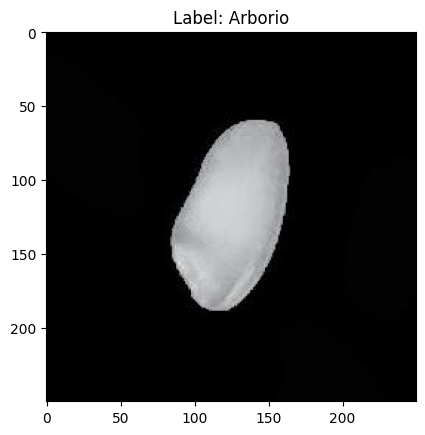

In [10]:
index = 500  # This selects the image from the training data by index number

image, label = trainset[index] # Get the image and its label

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {classes[label]}")
plt.show()

#### Preparing the Data for Training

I determine the lengths of the training and test datasets and subset my training data into training and validation dataset. After which I check to see how many batches there will be for each the training and validation datasets based on eight as the batchsize. Finally, I confirmed that the training data is a subset of the overall dataset.


In [11]:
len(trainset), len(testset)

(74400, 600)

In [12]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 24400])
len(trainset), len(valset), len(testset)

(50000, 24400, 600)

In [13]:
print(f'Number of batches in the training set: {int(50000 / batch_size)}')
print(f'Number of batches in the validation set: {int(24400 / batch_size)}')

Number of batches in the training set: 6250
Number of batches in the validation set: 3050


In [14]:
type(trainset)

torch.utils.data.dataset.Subset

#### Model Preparation

#### *Setup Data Loaders*

Since I am using a GPU, I generate loaders for all of my datasets. 

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#### *Define CNN Architecture*

Convolutional Neural Network (CNN) is a type of neural network architechture that excels in image classification, which is why it is used for this project. 

The convolution layers are are essentially responsible for recognizing patterns in the imput (images). The activation functions then introduce non-linearities to the network to encourage complex pattern recognition and data relationships. The pooling layers then act as a way to downsize the data or simplifying it, which is the opposite of what the activation layer does. This is to reduce overfitting. The fully connected layers are responsible for the predictions. It is then flattened before being outputted.

In [16]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Calculate the size of the flattened features after all convolutional and pooling layers
        self._flattened_features = self._get_conv_output_size()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=self._flattened_features, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.drop2 = nn.Dropout(p=0.3)
        self.out = nn.Linear(in_features=512, out_features=5)

    def _get_conv_output_size(self):
        # Create a dummy input to pass through the convolutional layers only
        dummy_input = torch.zeros(1, 3, 250, 250)  # Use the provided input dimensions
        dummy_input = self.conv1(dummy_input)
        dummy_input = self.pool1(dummy_input)
        dummy_input = self.conv2(dummy_input)
        dummy_input = self.pool2(dummy_input)
        dummy_input = self.conv3(dummy_input)
        dummy_input = self.pool3(dummy_input)
        return int(torch.flatten(dummy_input, 1).size(1))

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        # Output layer
        x = self.out(x)

        return x

#### *Push Model to Device and Verify Parameters*

I now have to push the model to the device since I am using a GPU. I am also checking to make sure the shape of my input and output features are correct and there will be 5 class labels.

In [17]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=230400, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=5, bias=True)
)

In [18]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

input shape: torch.Size([8, 3, 250, 250])


c:\GDAA2010\Basics_test\gdaa2010_dl\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


after network shape: torch.Size([8, 5])


I verify the number of parameters in the model, which is over 200 million.

In [19]:
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 237,192,325


#### *Select Loss Function and Optimization Technique*

I use `CrossEntropyLoss` for my loss function since it is ideal for multi-class classification models. Adam is used as the optimizer and I set my learning rate at 0.0001.

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

#### Define and Run the Training Loop

#### *Setup Training Epoch*
I define a function to setup the training epoch. This function is ensuring training loader, loss function and optimizer is set to iterate over the each batch and printing relevant information accross 100 batches. This calculates the running loss and running accuracy for the training dataset.

In [21]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99:  # print every 100 batches
      avg_loss_across_batches = running_loss / 100
      avg_acc_across_batches = (running_accuracy / 100) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

    
  print()

#### *Setup Validation Epoch*

This code chuck is nearly identical to the previous but this does not print the loss or accuracy for every x number of batches processed. Instead it outputs the final average loss and accuracy of the validation dataset.

In [22]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 5]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

#### *Train the Model*

Now we can train the model after defining the training and validation loops. In the end, running 10 epochs generated the best accuracy.

In [23]:
num_epochs = 10

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    validate_one_epoch()
    
print('Finished Training')

Epoch: 1



c:\GDAA2010\Basics_test\gdaa2010_dl\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Batch 100, Loss: 0.946, Accuracy: 59.9%
Batch 200, Loss: 0.366, Accuracy: 87.0%
Batch 300, Loss: 0.256, Accuracy: 89.9%
Batch 400, Loss: 0.225, Accuracy: 91.5%
Batch 500, Loss: 0.177, Accuracy: 94.6%
Batch 600, Loss: 0.197, Accuracy: 93.4%
Batch 700, Loss: 0.190, Accuracy: 93.9%
Batch 800, Loss: 0.119, Accuracy: 95.9%
Batch 900, Loss: 0.147, Accuracy: 94.8%
Batch 1000, Loss: 0.191, Accuracy: 94.0%
Batch 1100, Loss: 0.137, Accuracy: 95.1%
Batch 1200, Loss: 0.130, Accuracy: 95.8%
Batch 1300, Loss: 0.107, Accuracy: 96.2%
Batch 1400, Loss: 0.155, Accuracy: 94.4%
Batch 1500, Loss: 0.122, Accuracy: 95.5%
Batch 1600, Loss: 0.133, Accuracy: 95.6%
Batch 1700, Loss: 0.119, Accuracy: 95.4%
Batch 1800, Loss: 0.147, Accuracy: 94.9%
Batch 1900, Loss: 0.144, Accuracy: 95.0%
Batch 2000, Loss: 0.119, Accuracy: 95.9%
Batch 2100, Loss: 0.120, Accuracy: 95.8%
Batch 2200, Loss: 0.128, Accuracy: 96.0%
Batch 2300, Loss: 0.140, Accuracy: 95.8%
Batch 2400, Loss: 0.116, Accuracy: 96.0%
Batch 2500, Loss: 0.120, 

#### Evaluate the Model

Now that the training is completed it is time to evaluate the model using the test dataset. The accuracy of the model's prediction will be calculated with a classification report and confusion matrix generated.

In [24]:
# Get predicted labels from the model
predicted_labels = []
true_labels = []

# Iterate through test set and collect predictions
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=classes)


# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

Accuracy: 0.995


In [25]:
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     Arborio       0.99      0.98      0.99       120
     Basmati       1.00      1.00      1.00       120
      Ipsala       1.00      0.99      1.00       120
     Jasmine       0.98      1.00      0.99       120
   Karacadag       1.00      1.00      1.00       120

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600



In [26]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[118   0   0   2   0]
 [  0 120   0   0   0]
 [  1   0 119   0   0]
 [  0   0   0 120   0]
 [  0   0   0   0 120]]


Since the above does not really give us a lot of information, I visualize the confusion matrix using `matplotlib` and `seaborn` for better readability.

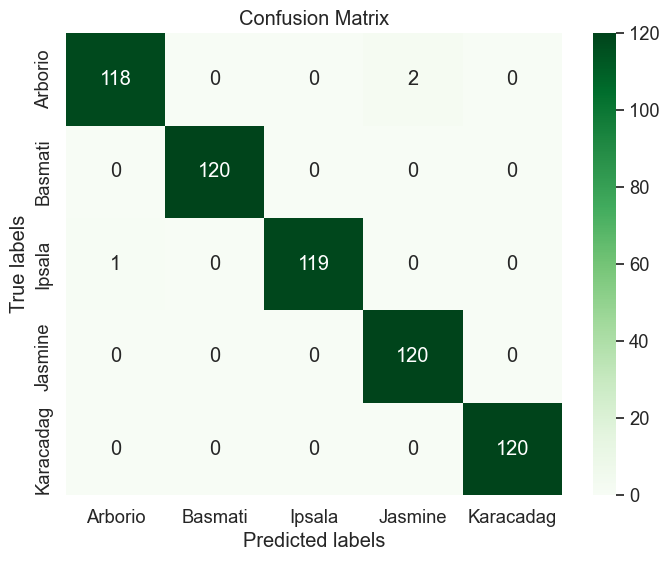

In [27]:
# Extract class labels from the dataset
class_labels = testset.classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Set font scale
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

#### Saving the Trained Model

The model performs very well so I will be saving this model so training is not necessary for every prediction on new datasets.

In [28]:
# Define the directory path to save the model
save_dir = r"C:\GDAA2010\Basics_test\models"

# Define the file name for the saved model
model_name = "rice_epoch10.pth"
save_path = os.path.join(save_dir, model_name)

# Save the model
torch.save(net.state_dict(), save_path)

print(f"Model saved at: {save_path}")

Model saved at: C:\GDAA2010\Basics_test\models\rice_epoch10.pth


I will now load this model into my project and test the same test data to ensure it is working. I also added the `load_state_dict` function in the next code chunk. When I did not have that line of code, my accuracy was outputting only less than 30% which gave pause since my accuracy before was at 99.5%. When I did not have that line, `NeuralNet()` was initialized randomly therefore any weights and biases (parameters) that were used in the saved model was not loaded in.

In [31]:
# Move the model to the GPU
net_test = NeuralNet()
net_test.load_state_dict(torch.load(save_path))
net_test.to(device)

# Evaluate the model on the test data
net_test.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net_test(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2f}%")

Accuracy of the network on the test images: 99.50%


#### Conclusion

Overall, based on the results, the model accuracy was incredible. The precision, recall, and f1-score were between 0.99 to 1.00 with an overall accuracy of 0.995 or 99.5%. When the training initially started, the first 100 batches in the first epoch was only at a 59.9% accuracy which quickly climbed to above 90% after the fist few hundred batched. This success in acccuracy could be attributed to the lack of noise of the images - having consistently a dark background and a contrasting white grain of rice. The size of the dataset was also a contributor as the model had thousands of images to learn and observe patterns. However, the model did take over two hours finish due to the large dataset. Having 10 epochs certainly contributed to the long processing time. Additionally, the validation accuracies at the end of each epoch plateaued towards the middle, decreased, then finally went back to a fairly high accuracy.

in conclusion, I was happy with the results and saved the model for future use and tested it to ensure it was working correctly.